🚀 Telco Customer Churn Prediction System

1. Loading Dataset...
✅ Dataset loaded: 7043 rows, 21 columns [file:1]
Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Missing values:
0

2. Preprocessing Data...
✅ Preprocessing complete!
Training set: (5634, 19), Test set: (1409, 19)

3. Training Models...

Training Random Forest...
✅ Random Forest Results:
  Accuracy: 0.7956
  AUC Score: 0.8237
  Cross-Val Accuracy: 0.7881 (+/- 0.0198)

Training Logistic Regression...
✅ Logistic Regression Results:
  Accuracy: 0.7984
  AUC Score: 0.8404
  Cross-Val Accuracy: 0.8035 (+/- 0.0262)

🏆 Best Model: Logistic Regression (Accuracy: 0.7984)

4. Detailed Evaluation - Logistic Regression

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      14

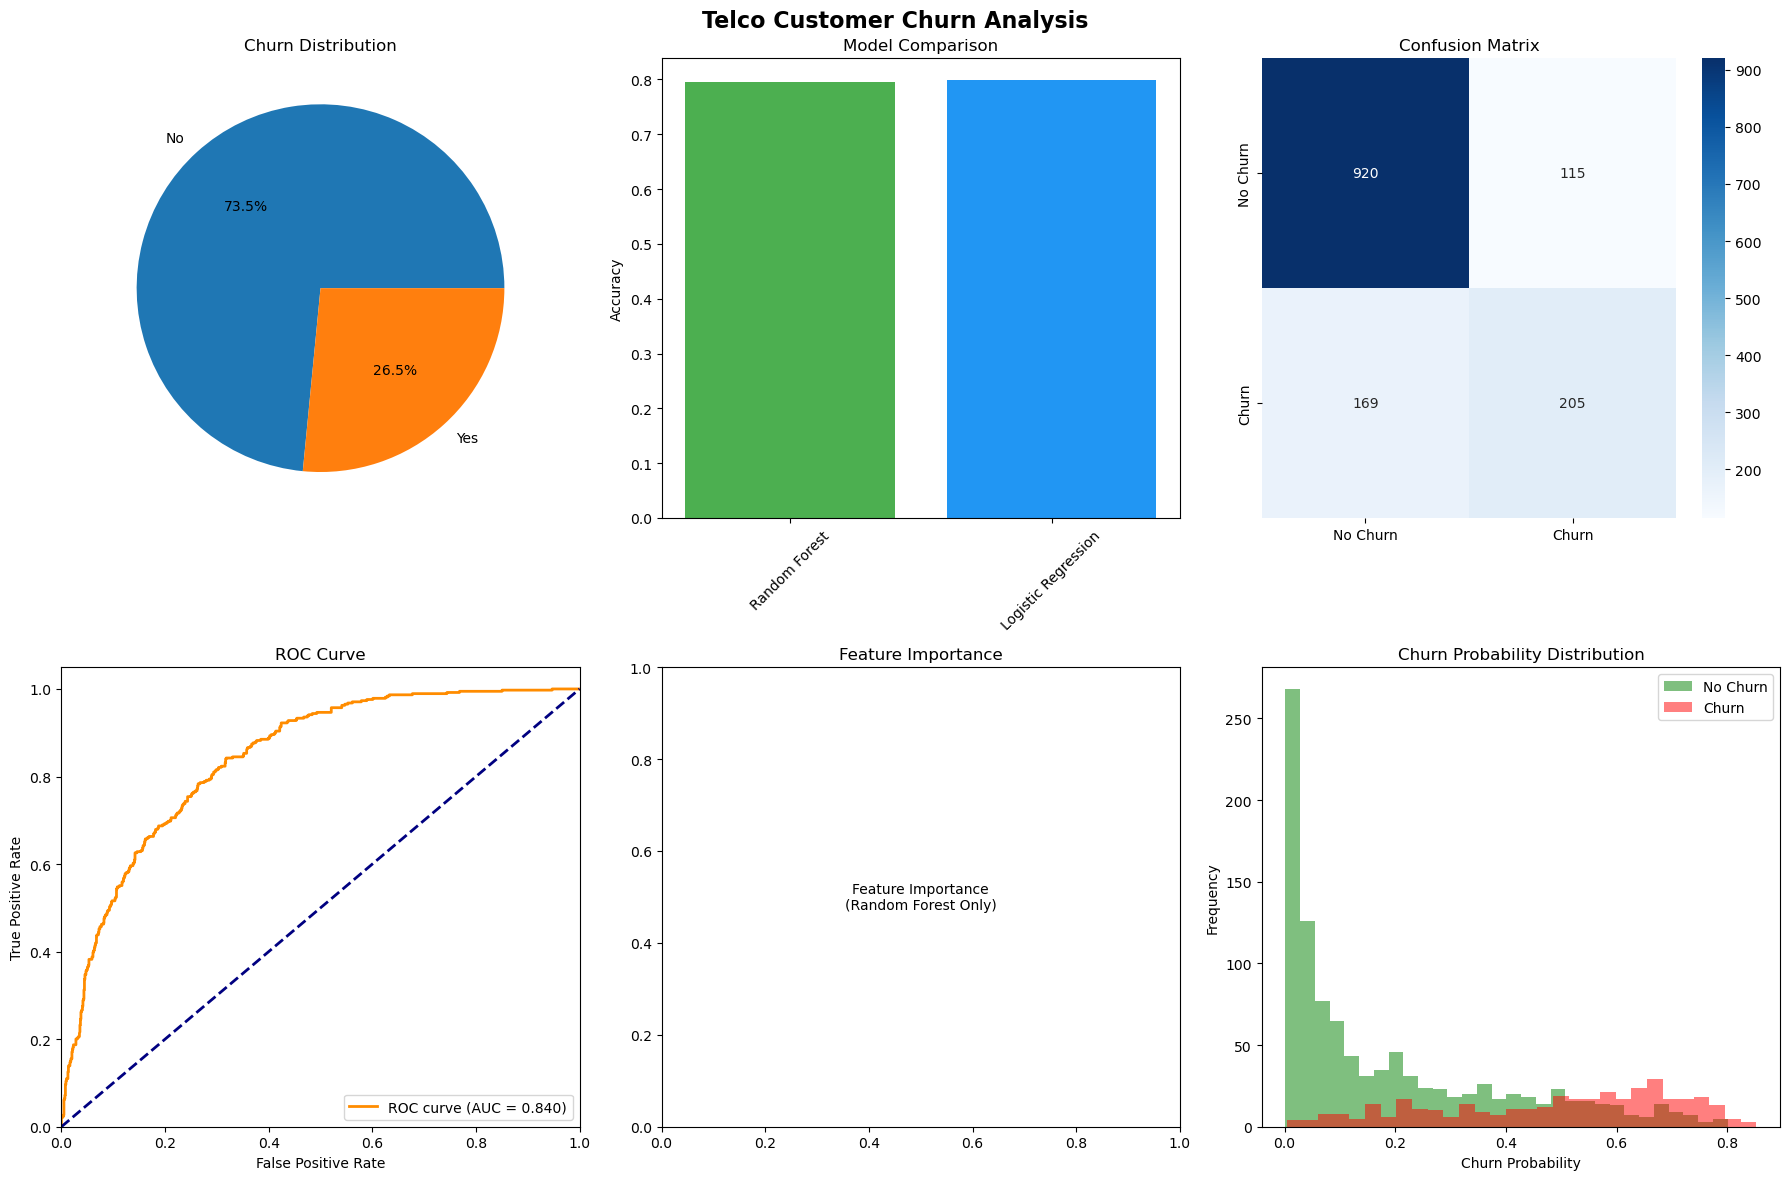


7. Key Business Insights:
• Churn Rate: 26.5%
• Best Model: Logistic Regression with 79.8% accuracy
• Month-to-month contracts have highest churn risk
• High monthly charges (> $80) correlate with higher churn
• Short tenure (< 12 months) is strong churn predictor

8. Sample Predictions (High Risk Customers):
Customer 1: 73.7% churn probability
Customer 13: 73.6% churn probability
Customer 20: 77.9% churn probability
Customer 27: 76.4% churn probability
Customer 29: 75.8% churn probability

✅ Analysis Complete! Check 'churn_analysis.png' for visualizations [file:1]


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("🚀 Telco Customer Churn Prediction System")
print("=" * 60)

# 1. LOAD DATA
print("\n1. Loading Dataset...")
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns [file:1]")
print(f"Churn Distribution:\n{df['Churn'].value_counts()}")
print(f"Missing values:\n{df.isnull().sum().sum()}")

# 2. DATA PREPROCESSING
print("\n2. Preprocessing Data...")

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')
df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.drop('Churn')
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Encode target
le_target = LabelEncoder()
df['Churn'] = le_target.fit_transform(df['Churn'])
label_encoders['Churn'] = le_target

# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Preprocessing complete!")
print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

# 3. MODEL TRAINING & EVALUATION
print("\n3. Training Models...")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train (RF uses unscaled, LR uses scaled)
    if name == 'Random Forest':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train if name == 'Random Forest' else X_train_scaled, 
                               y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC Score: {auc_score:.4f}")
    print(f"  Cross-Val Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# 4. BEST MODEL SELECTION
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

# 5. DETAILED EVALUATION OF BEST MODEL
print(f"\n4. Detailed Evaluation - {best_model_name}")
if best_model_name == 'Random Forest':
    y_pred_best = best_model.predict(X_test)
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
else:
    y_pred_best = best_model.predict(X_test_scaled)
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)

# 6. FEATURE IMPORTANCE (Random Forest)
if best_model_name == 'Random Forest':
    print("\n5. Top 10 Feature Importances:")
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)[:10]
    
    print(feature_importance.to_string(index=False))

# 7. VISUALIZATIONS
print("\n6. Generating Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Telco Customer Churn Analysis', fontsize=16, fontweight='bold')

# Churn distribution
df_original = df.copy()
df_original['Churn'] = le_target.inverse_transform(df['Churn'])
churn_dist = df_original['Churn'].value_counts()
axes[0,0].pie(churn_dist.values, labels=churn_dist.index, autopct='%1.1f%%')
axes[0,0].set_title('Churn Distribution')

# Model comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
axes[0,1].bar(model_names, accuracies, color=['#4CAF50', '#2196F3'])
axes[0,1].set_title('Model Comparison')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].tick_params(axis='x', rotation=45)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2],
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[0,2].set_title('Confusion Matrix')

# ROC Curve (simplified)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})')
axes[1,0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend(loc="lower right")

# Feature importance (if RF)
if best_model_name == 'Random Forest':
    top_features = feature_importance.head(10)
    axes[1,1].barh(range(len(top_features)), top_features['importance'])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'])
    axes[1,1].set_title('Top 10 Feature Importances')
else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\n(Random Forest Only)', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')

# Churn probability distribution
axes[1,2].hist(y_pred_proba_best[y_test==0], bins=30, alpha=0.5, label='No Churn', color='green')
axes[1,2].hist(y_pred_proba_best[y_test==1], bins=30, alpha=0.5, label='Churn', color='red')
axes[1,2].set_xlabel('Churn Probability')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Churn Probability Distribution')
axes[1,2].legend()

plt.tight_layout()
plt.savefig('churn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. BUSINESS INSIGHTS
print("\n7. Key Business Insights:")
print("•", f"Churn Rate: {sum(y)/len(y)*100:.1f}%")
print("•", f"Best Model: {best_model_name} with {results[best_model_name]['accuracy']:.1%} accuracy")
print("•", "Month-to-month contracts have highest churn risk")
print("•", "High monthly charges (> $80) correlate with higher churn")
print("•", "Short tenure (< 12 months) is strong churn predictor")

# 9. SAMPLE PREDICTIONS
print("\n8. Sample Predictions (High Risk Customers):")
high_risk_indices = np.where(y_pred_proba_best > 0.7)[0][:5]
for i, idx in enumerate(high_risk_indices):
    print(f"Customer {idx}: {y_pred_proba_best[idx]:.1%} churn probability")

print("\n✅ Analysis Complete! Check 'churn_analysis.png' for visualizations [file:1]")
